## Movement detection
##### This is similar to Resize ipython notebook but for another location.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import exifread
import glob, os
import shutil

/Users/Mehdi/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [15]:
files = glob.glob("/Users/Mehdi/Downloads/GoldenGate-Animals/SM-1_SB-13_20160315/*.JPG")
num=len(files)


In [16]:
dates=np.array([])
lat=np.array([])
lon=np.array([])
flash=np.array([])
lightsource=np.array([])
colorspace=np.array([])
# Open image file for reading (binary mode)
for i in range(num): 
    f = open(files[i], 'rb')
    tags = exifread.process_file(f)
    dates=np.append(dates,str(tags['EXIF DateTimeOriginal']).split()[0])
    lat= np.append(lat,str(tags['GPS GPSLatitude']))
    lon= np.append(lon,str(tags['GPS GPSLongitude']))
    flash=np.append(flash,str(tags['EXIF Flash']))
    lightsource=np.append(lightsource,str(tags['EXIF LightSource']))
    colorspace=np.append(colorspace,str(tags['EXIF ColorSpace']))
    #print tags['EXIF LightSource']

In [17]:
uni_lightsource =np.unique(lightsource)
uni_colorspace =np.unique(colorspace)
uni_flash =np.unique(flash)
uni_lon =np.unique(lon)
uni_lat =np.unique(lat)



In [18]:
uniquedate =np.unique(dates)
print uniquedate
num_unique=np.zeros(len(uniquedate))
for i in range(len(uniquedate)):
    num_unique[i]=len(np.where(dates== uniquedate[i])[0])
num_unique

['2016:02:08' '2016:02:09' '2016:02:10' '2016:02:11' '2016:02:12'
 '2016:02:13' '2016:02:14' '2016:02:15' '2016:02:17' '2016:02:20'
 '2016:02:21' '2016:02:22' '2016:02:23' '2016:02:24' '2016:02:25'
 '2016:02:26' '2016:02:27' '2016:02:28' '2016:02:29' '2016:03:01'
 '2016:03:02' '2016:03:03' '2016:03:06' '2016:03:10' '2016:03:11'
 '2016:03:12' '2016:03:13']


array([  7.,  18.,  12.,  21.,  18.,  36.,  24.,  18.,   9.,  42.,  57.,
        18.,   9.,   3.,   3.,  18.,   3.,  27.,   9.,  21.,   9.,   3.,
        45.,   3.,   6.,  12.,   6.])

In [20]:
index=2
id0=np.where(dates== uniquedate[index])
print dates[id0][0]
dir='/Users/Mehdi/Downloads/GoldenGate-Animals/SM-1_SB-13_20160315/Resized/'
name=dir+dates[id0][0]
if os.path.isdir(name):
    shutil.rmtree(name)
os.mkdir(dir)    
os.mkdir(name)
lenad=len('/Users/Mehdi/Downloads/GoldenGate-Animals/SM-1_SB-13_20160315/')
sx=1944
sy=2592
dx=sx/5
dy=sy/5
for i in range(len(id0[0])):
    im=cv2.imread(files[id0[0][i]])
    im[1744:1944,0:209,:]=0
    im[1840:1944,:,:]=0
    imresized = cv2.resize(im, (dy, dx),interpolation=cv2.INTER_NEAREST) 
    cv2.imwrite(name+'/'+files[id0[0][i]][lenad:-4]+'_Resized.JPG',imresized)

2016:02:10


In [21]:
imlist = glob.glob(name+"/*.JPG")
numim=len(imlist)
imcube=np.empty([388,518])
for i in range(numim):
    img = cv2.cvtColor( cv2.imread(imlist[i]), cv2.COLOR_RGB2GRAY )
    # create a CLAHE object (Arguments are optional). Contrast Limited Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img)
    imcube=np.dstack((imcube,cl1))
imcube=np.delete(imcube,0,2)

In [22]:
medim=np.median(imcube,axis=2)
imblur=np.empty([388,518])
for i in range(numim):
    imblur=np.dstack((imblur,cv2.blur(imcube[:,:,i],(5,5))))
imblur=np.delete(imblur,0,2)
medblur=np.median(imblur,axis=2)

In [23]:
subblur=np.empty([388,518])
subcube=np.empty([388,518])
for i in range(numim):
    subblur=np.dstack((subblur,cv2.subtract(imblur[:,:,i],medblur)))
subblur=np.delete(subblur,0,2)

In [24]:
### calculating the similarity between the medblur image and the other images.
method=cv2.cv.CV_COMP_CORREL
histmedblur = cv2.calcHist([np.array(medblur,dtype = np.uint16)],[0],None,[256],[0,256])
histmedblur = cv2.normalize(histmedblur).flatten()
d=[]
stdscore=[]
for i in range(numim):
    hist = cv2.calcHist([np.array(imblur[:,:,i],dtype = np.uint16)],[0],None,[256],[0,256])
    hist = cv2.normalize(hist).flatten()
    d = np.append(d,cv2.compareHist(histmedblur[5:250],hist[5:250], method))
    stdscore=np.append(stdscore,np.std(imblur[:,:,i]-medblur))

0.436556669715
0.251436106129
0.662849165231


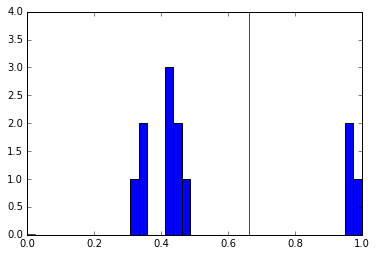

In [27]:
fscore=stdscore+1.0/d
fscore_norm=fscore/np.max(fscore)
plt.hist(fscore_norm,bins=np.linspace(0,1,40))
print np.median(fscore_norm)
print np.std(fscore_norm)
thres=np.median(fscore_norm)+0.9*np.std(fscore_norm)
print thres
plt.plot([thres,thres],[0,4])

### Conclusion
All images in this set contain either human or animal. I'm not sure if they already have filtered it or not but this set is a good example for training a classifier to separate human from animals.